<a href="https://colab.research.google.com/github/erisson23/AIEQ/blob/main/Tarefa2_Erisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [85]:
#Bibliotecas

In [86]:
import cv2
import zipfile
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import skimage.feature
from string import digits
import seaborn as sns
import skimage

In [87]:
#Carregando arquivo trash

In [88]:
!gdown --id 1L4mdCDBgybKqr5Wo-kqT8HXcBJ9HXqSX

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1L4mdCDBgybKqr5Wo-kqT8HXcBJ9HXqSX
To: /content/trash_nov_22_2018.zip
100% 42.8M/42.8M [00:00<00:00, 112MB/s]


In [89]:
FILE='trash_nov_22_2018.zip'

In [90]:
archive = zipfile.ZipFile('trash_nov_22_2018.zip', 'r')
archive.extractall()

In [91]:
img_name=[]
with zipfile.ZipFile(FILE, "r") as f:
    for name in f.namelist():
        img_name.append(name)

In [92]:
Img_Size = 80
ref = 'jpg'
notref = 'met'

In [93]:
#Dimensões

In [94]:
X= []
Y =[]
n = len(img_name)
i = 0
for i in range(n):
  name = img_name[i]
  if(ref in name):
    Y.append(name)
    #X.append(cv2.imread(name,0))
    X.append(cv2.imread(name))
m = len(Y)
print(n,m)

2527 2527


In [108]:
name[-3:]

'jpg'

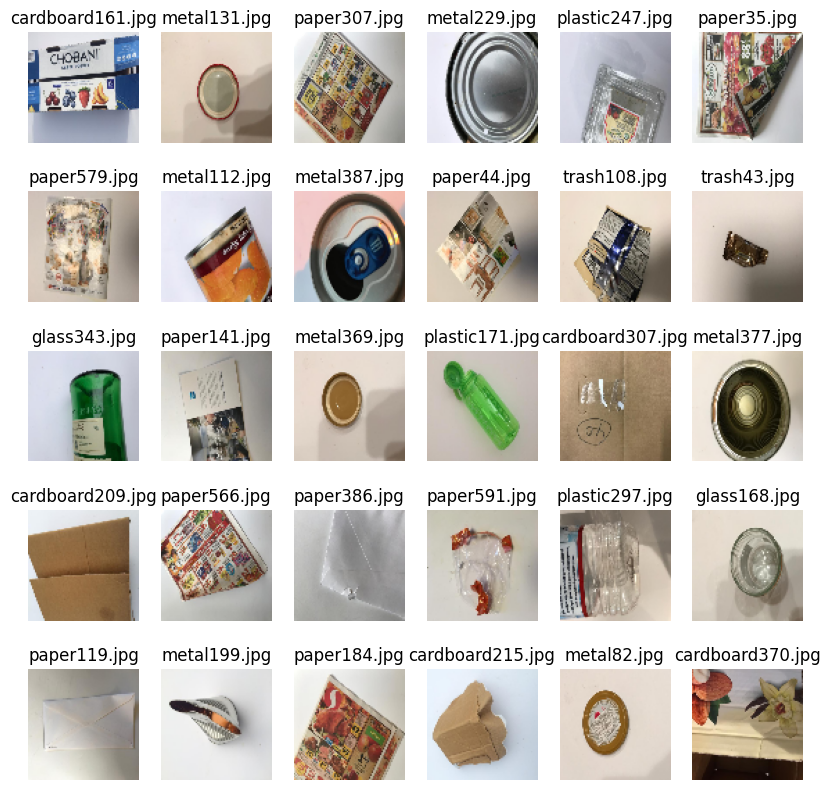

In [109]:
plt.figure(figsize=(10, 10))
m = len(Y)
for i in range(30): #30 fotos
  ax = plt.subplot(5, 6, i + 1) # 5 linhas e 6 colunas
  idx = np.random.randint(m)
  RGB_img = cv2.cvtColor(X[idx], cv2.COLOR_BGR2RGB)
  resized = cv2.resize(RGB_img, (Img_Size,Img_Size))
  plt.imshow(resized)
  plt.title(Y[idx])
  plt.axis("off")

In [97]:
#16 fotos sequênciais

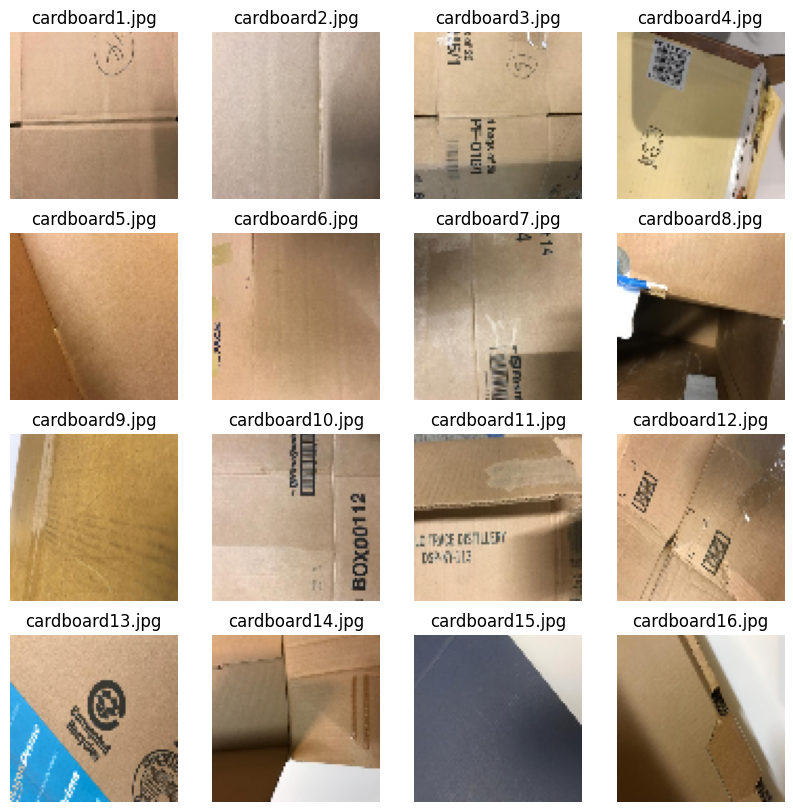

In [110]:
plt.figure(figsize=(10, 10))
X_test = X
Y_test = Y
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  RGB_img = cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB)
  resized = cv2.resize(RGB_img, (Img_Size,Img_Size))
  plt.imshow(resized)
  plt.title(Y_test[i])
  plt.axis("off")

In [99]:
#Cria uma lista com as 4 primeiras letras de cada item armazenado

In [116]:
label =[]
for name in img_name:
  for idx, x in enumerate(types):
    if(x in name):
      label.append(idx)

In [117]:
df=pd.DataFrame(label,columns=['target'])

In [118]:
y = pd.get_dummies(df['target'])

In [123]:
n =len(img_name)
tipos = []
selected = 'find'
for x in img_name:
  result =''.join([i for i in x[:-4] if not i.isdigit()])
  if(result != selected):
    selected = result
    tipos.append(selected)


In [124]:
for i in range(6):
  n= df[(df["target"] == i)].shape[0]
  print(tipos[i],':',n)

cardboard : 0
glass : 0
metal : 0
paper : 0
plastic : 0
trash : 0


In [125]:
from sklearn.model_selection import train_test_split

In [126]:
n =len(img_name)
data = np.empty((n, 224, 224, 3))

In [127]:
DATASET_SIZE = len(img_name)
Ind = range(DATASET_SIZE)
Ind_train, Ind_test= train_test_split(Ind,test_size=0.20, stratify=label, shuffle=True, random_state=3)
X = np.array(X)
X_train=X[Ind_train]
X_test = X[Ind_test]
y_train=y.iloc[Ind_train,:]
y_test = y.iloc[Ind_test,:]

ValueError: ignored

In [ ]:
from keras.applications.mobilenet_v2 import preprocess_input
from skimage.transform import resize
i = 0
for im in X:
    im = preprocess_input(im)
    im = resize(im, output_shape=(224, 224))
    data[i] = im
    i += 1

In [ ]:
n=len(img_name)
m=len(tipos)

idx = 0
labels_tf = np.empty([n,m], dtype=int)
for yi in y.values:
  labels_tf[idx] = yi
  idx = idx + 1

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
model = ResNet50(weights='imagenet')

In [ ]:
from keras.applications.mobilenet_v2 import decode_predictions

predictions = model.predict(data)
k = 0
for decoded_prediction in decode_predictions(predictions, top=1):

  for name, desc, score in decoded_prediction:
      if(k % 200 ==0):
        print('- {} ({:.2f}%%) {}'.format(desc, 100 * score,img_name[k]))
  k = k +1

In [ ]:
print(len(model.layers))
fine_tune_at = 160
for layer in model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
D =len(types)
model_output = Dense(D, activation= 'softmax')
model_output = model_output(model.layers[-2].output)
model_input = model.input
model_new = Model(inputs=model_input, outputs=model_output)

In [ ]:
model_new.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
r = model_new.fit(
    x=X_train,
    y=y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    verbose=2
)

In [ ]:
def retorna(y):
  resp = []
  for yi in y:
    vmax =max(yi)
    for idx, x in enumerate(yi):
      if(x == vmax):
        resp.append(idx)
  return resp

In [ ]:
test_loss, test_acc = model_new.evaluate(X_test,  y_test, verbose=2)

In [ ]:
predict=model_new.predict(X_test)

In [ ]:
predict[0].shape

In [ ]:
y_calc = retorna(predict)
y_test = retorna(np.array(y_test))

In [ ]:
confusion_matrix(y_test, y_calc)

In [ ]:
# Classification Report
print('\n\n', classification_report(y_test, y_calc, target_names=tipos))

In [ ]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [ ]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()